# Justify watershed:

- We do that by first proving watersheds are superior in isolating the progenitors of massive z=0 halos at z=2.5. 
- Then we find the completness of our progenitor detections. 
- In this section we use some auxillary file stored in `./Lytomo_data/progenitors/` which \
are the postprocessed data from TNG simulations.

## Isolating the ptogenitors (Figure 7):

In [1]:
import h5py
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter as gf
import numpy as np
import importlib
plt.style.use('Notebook.mystyle')

In [5]:
from scipy.ndimage import gaussian_filter as gf
import h5py
import numpy as np

def detected_progs(flux_map=None, lmap=None, peaks=None, mlim=[13.5, np.inf], thresh=-2.0, contours=False, parents=False, watersheds=False):
    """Find and count the detected progenitors more massive than mlim within 
    each contour"""
    if contours:
        import codes.minima as minima
        flux_map = gf(flux_map, sigma=4, mode='wrap')
        _ , lmap = minima.find_extrema_v3(mapconv=flux_map,
                                          thresh=thresh, linking_contour=-thresh)
    
    fcofm = h5py.File('../LyTomo_data/progenitors/cofm_progenitors.hdf5','r')
    all_clusters = h5py.File('../LyTomo_data/progenitors/clusters_TNG300-1.hdf5','r')
    # Select only massive progenitors
    Mass = np.log10(all_clusters['Mass'][:])+10
    indm = np.where((Mass > mlim[0])*(Mass < mlim[1]))[0]
    indm = np.isin(fcofm['cluster_ind'][:], indm, assume_unique=True)
    prog = np.zeros((205,205,205))
    x = fcofm['x'][:][indm].astype(int)
    y = fcofm['y'][:][indm].astype(int)
    z = fcofm['z'][:][indm].astype(int)
    # Count progenitors from 1 not 0
    prog[x,y,z] = fcofm['cluster_ind'][:][indm]+1
    
    detected_progs_num = np.array([])
    if contours :
        ind = np.unique(lmap)[1::]
        for j in ind :
            contour = np.zeros_like(lmap, dtype=int)
            contour[np.where(lmap==j)] = 1
            overlap_progs = np.unique(prog*contour).astype(int)[1::]
            detected_progs_num = np.append(detected_progs_num, overlap_progs.size)
    if parents :
        parents = np.unique(peaks['parentid'][:])
        for j in parents :
            SubregionIDs = np.where(peaks['parentid'][:] == j)[0] + 1
            contour = np.zeros_like(lmap, dtype=int)
            contour[np.isin(lmap, SubregionIDs)] = 1
            overlap_progs = np.unique(prog*contour).astype(int)[1::]
            detected_progs_num = np.append(detected_progs_num, overlap_progs.size)
    if watersheds :
        for i in range(1,peaks['x'].size+1):
            contour = np.zeros((205,205,205), dtype=int)
            ind = np.where(lmap == i)
            contour[ind] = 1
            overlap_progs = np.unique(prog*contour).astype(int)[1::]
            detected_progs_num = np.append(detected_progs_num, overlap_progs.size)        
    
    return detected_progs_num


def detected_progs_parents(lmap, peaks, mlim=[13.5, np.inf]):
    """Find and count the detected progenitors more massive than mlim within each 
    parent countour. The difference with the code above is in excluding the contours 
    hosting only peaks with significance between nu= -2.0 ansd kappa= -2.35. """
    
    fcofm = h5py.File('../LyTomo_data/progenitors/cofm_progenitors.hdf5','r')
    all_clusters = h5py.File('../LyTomo_data/progenitors/clusters_TNG300-1.hdf5','r')
    # Select only massive progenitors
    Mass = np.log10(all_clusters['Mass'][:])+10
    indm = np.where((Mass > mlim[0])*(Mass < mlim[1]))[0]
    indm = np.isin(fcofm['cluster_ind'][:], indm, assume_unique=True)
    prog = np.zeros((205,205,205))
    x = fcofm['x'][:][indm].astype(int)
    y = fcofm['y'][:][indm].astype(int)
    z = fcofm['z'][:][indm].astype(int)
    # Count progenitors from 1 not 0
    prog[x,y,z] = fcofm['cluster_ind'][:][indm]+1
    
    detected_progs_num = np.array([])
    parents = np.unique(peaks['parentid'][:])
    for j in parents :
        SubregionIDs = np.where(peaks['parentid'][:] == j)[0] + 1
        contour = np.zeros_like(lmap, dtype=int)
        contour[np.isin(lmap, SubregionIDs)] = 1
        overlap_progs = np.unique(prog*contour).astype(int)[1::]
        detected_progs_num = np.append(detected_progs_num, overlap_progs.size)
        
    return detected_progs_num

def detected_progs_watersheds(lmap, peaks, mlim=[13.5, np.inf]):
    """Find and count the detected progenitors more massive than 
    mlim within each watershed"""
    fcofm = h5py.File('../LyTomo_data/progenitors/cofm_progenitors.hdf5','r')
    all_clusters = h5py.File('../LyTomo_data/progenitors/clusters_TNG300-1.hdf5','r')
    # Select only massive progenitors
    Mass = np.log10(all_clusters['Mass'][:])+10
    indm = np.where((Mass > mlim[0])*(Mass < mlim[1]))[0]
    indm = np.isin(fcofm['cluster_ind'][:], indm, assume_unique=True)
    prog = np.zeros((205,205,205))
    x = fcofm['x'][:][indm].astype(int)
    y = fcofm['y'][:][indm].astype(int)
    z = fcofm['z'][:][indm].astype(int)
    # Count progenitors from 1 not 0
    prog[x,y,z] = fcofm['cluster_ind'][:][indm]+1
    
    detected_progs_num = np.array([])
    for i in range(1,peaks['x'].size+1):
        contour = np.zeros((205,205,205), dtype=int)
        ind = np.where(lmap == i)
        contour[ind] = 1
        overlap_progs = np.unique(prog*contour).astype(int)[1::]
        detected_progs_num = np.append(detected_progs_num, overlap_progs.size)
        
    return detected_progs_num


In [ ]:
%%time
nrange = np.arange(1,21)
detected_contours, detected_parents, detected_subregions = [], [], []
for n in nrange:
    print(n)
    detected_contours.append(detected_progs(contours=True, thresh=-2.0,
                                            flux_map = np.fromfile('../LyTomo_data/mock_maps_z2.4/map_TNG_z2.4_n'
                                                                   +str(n)+'.dat').reshape((205,205,205))))
    detected_subregions.append(detected_progs(watersheds=True,
                                              lmap = h5py.File('../LyTomo_data/watersheds_z2.4/mocks/n'+str(n)
                                                               +'/labeled_map_TNG_z2.4_n'+str(n)+'_sigma4_th2.35_lc2.00.hdf5',
                                                               'r')['map'][:], 
                                              peaks= h5py.File('../LyTomo_data/watersheds_z2.4/mocks/n'+str(n)
                                                               +'/peaks_TNG_z2.4_n'+str(n)+'_sigma4_th2.35_lc2.00.hdf5','r')))
    detected_parents.append(detected_progs(parents=True,
                                           lmap = h5py.File('../LyTomo_data/watersheds_z2.4/mocks/n'+str(n)
                                                            +'/labeled_map_TNG_z2.4_n'+str(n)+'_sigma4_th2.35_lc2.00.hdf5',
                                                            'r')['map'][:], 
                                           peaks= h5py.File('../LyTomo_data/watersheds_z2.4/mocks/n'+str(n)
                                                            +'/peaks_TNG_z2.4_n'+str(n)+'_sigma4_th2.35_lc2.00.hdf5','r')))


In [12]:
def write_detected_progs():
    with h5py.File('../LyTomo_data/progenitors/prog_counts_z2.4_sigma4.hdf5','w') as fw:
        for i, n in enumerate(np.arange(1,21)):
            fw[str(n)+'/contours'] = detected_contours[i]
            fw[str(n)+'/subregions'] = detected_subregions[i]
            fw[str(n)+'/parents'] = detected_parents[i]

Plot the mean counts :

In [13]:
def plot_prog_count_for_paper(num_mocks=20, savefig='islands_subregions_progs_count_noiseless.png', 
                              xmax=4, density=False):
    fig, ax = plt.subplots(1, 2, figsize=(15,10), gridspec_kw={'width_ratios': [5, 1]})

    mlim=[13.5,np.inf]
    
    f = h5py.File('../LyTomo_data/plotting_data/prog_counts_z2.4_sigma4.hdf5','r')
    colors = ['C0','C1','C2']
    dets = ['contours', 'parents', 'subregions']
    ls= ['solid', '-.', 'dashed']
    label=['Islands ',
           r'$\mathrm{Islands \ with \ (\delta_F /\sigma)_{peak} \leq \kappa \ = -2.35}$',
           'Watersheds']
    
    def _plot_hist(det, label, ls, color):
        bins= np.arange( -0.5, 50.5, 1.)
        mbins = np.array([(bins[b]+bins[b+1])/2 for b in range(bins.size-1)])
        counts = np.zeros((num_mocks,mbins.size))
        for i,n in enumerate(np.arange(1,num_mocks+1)):
            counts_temp, _ = np.histogram(f[str(n)+'/'+str(det)], bins, density=False)
            counts[i] = counts_temp
        # Count how many watersheds host more than xmax progenitors within them
        counts_large = np.sum(counts[:,mbins>=xmax], axis=1)
        # Set the summed counts to the counts on mbins=xmax
        counts[:,int(xmax)] = counts_large
        median_counts = np.around(np.median(counts, axis=0))
        std_counts = np.around(np.std(counts, axis=0))
        det_median = np.repeat(mbins, median_counts.astype(int))
        hist = ax[0].hist(det_median, bins=bins, histtype='step', label=label,ls=ls, linewidth=9, density=density, color=color, alpha=0.7)
        ax[0].errorbar(mbins, median_counts, yerr=std_counts, fmt='.', capsize=7, capthick=6, linewidth=5, alpha=0.7)
        # Plot the other chunck  of the plot showing the counts on mbins>=xmax
        ax[1].hist(det_median, bins=bins, histtype='step', linewidth=9, ls=ls, density=density, color=color, alpha=0.7)
        
        median = np.around(np.median(counts[:,int(xmax)]))
        std = np.around(np.std(counts[:,int(xmax)]))
        print(median, std)
        print(median, std)
        ax[1].errorbar(xmax, int(median), yerr=std, fmt='.', capsize=7, capthick=6, linewidth=5, alpha=0.7)
        
    for i in range(3):
        _plot_hist(dets[i], label=label[i], ls=ls[i], color=colors[i])
    
    plt.setp(ax[1], xticks = [xmax], xticklabels=['> '+str(xmax)])
    ax[0].set_xlim((-1,xmax-0.52))
    ax[1].set_xlim(xmax-0.5,xmax+0.5)
    if density:
        ax[0].set_ylim((0,1))
        ax[1].set_ylim((0,1))
    else:
        ax[0].set_ylim((0,110))
        ax[1].set_ylim((0,110))
            
    ax[0].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].yaxis.tick_right()
    ax[1].tick_params(labelright=False) 

    d = .9  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=40,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax[0].plot([1.05, 1.07], [0, 0], transform=ax[0].transAxes, **kwargs)
    ax[0].plot([1.05, 1.07], [1, 1], transform=ax[0].transAxes, **kwargs)
    ax[0].set_xlabel('# of progenitor being hosted')
    ax[0].set_ylabel('# of islands or watersheds')
    ax[0].grid(True, alpha=0.6)
    ax[1].grid(True, alpha=0.6)
    fig.legend(loc='upper right', bbox_to_anchor=(1,0.95), fontsize=24)
    plt.tight_layout()
    plt.savefig(savefig, transparent=False)

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


15.0 2.0
15.0 2.0
15.0 2.0
15.0 2.0
5.0 2.0
5.0 2.0


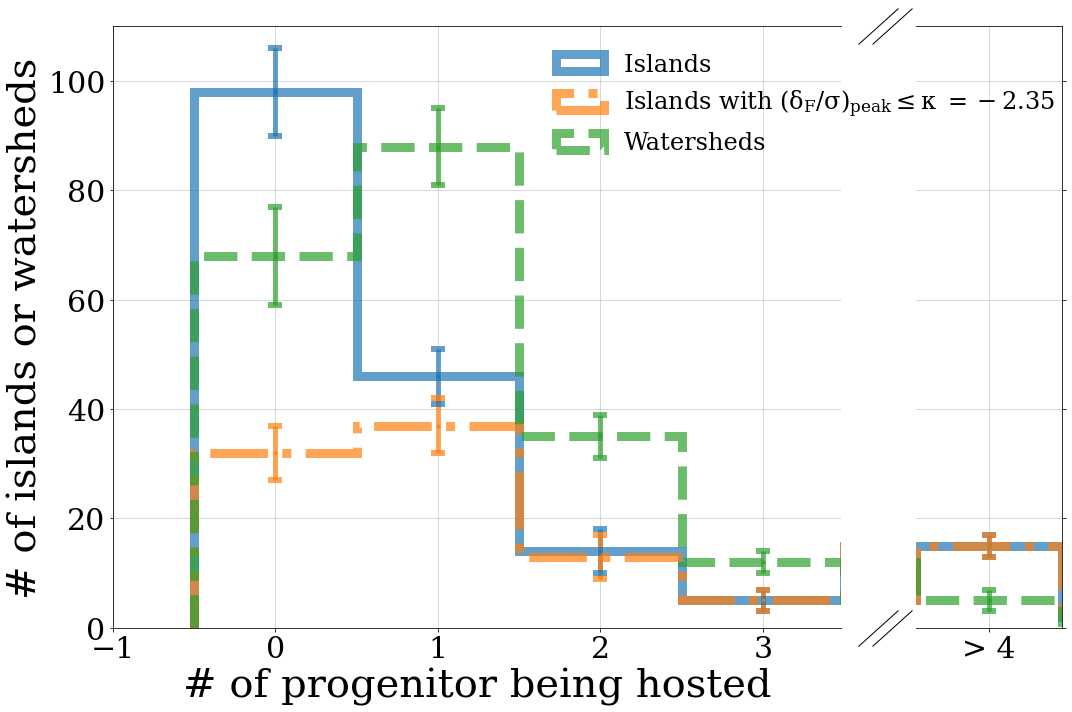

In [14]:
plot_prog_count_for_paper(savefig='./figures/islands_subregions_progs_count_mock.pdf', density=False)

## Completeness (Figure 11) :

In [17]:
def get_mean_std_hmf(nmocks=20):
    
    all_GMass = 10+np.log10(h5py.File('../LyTomo_data/descendants/all_halos_z0.hdf5',
                                      'r')['GroupMass'][:])
    bins = np.arange(12,16.5, 0.3)
    mbin = np.array([(bins[i+1]+bins[i])/2 for i in range(bins.size - 1)])
    ind = np.where(all_GMass > 13.5)
    hist_all, _ = np.histogram(all_GMass[ind], bins, density=False )
    
    all_clusters = h5py.File('../LyTomo_data/progenitors/clusters_TNG300-1.hdf5','r')
    # Select only massive progenitors
    Mass = np.log10(all_clusters['Mass'][:])+10
    prog = np.zeros((205,205,205), dtype=int)
    fcofm = h5py.File('../LyTomo_data/progenitors/cofm_progenitors.hdf5','r')
    x, y, z = fcofm['x'][:].astype(int), fcofm['y'][:].astype(int), fcofm['z'][:].astype(int)
    # Count progenitors from 1 not 0
    prog[x,y,z] = fcofm['cluster_ind'][:]+1
    
    counts_all_mock, counts_all_true = np.empty((nmocks,mbin.size)), np.empty((nmocks,mbin.size))
    for i,n in enumerate(np.arange(1,nmocks+1)):
        lmap_mock = h5py.File('../LyTomo_data/watersheds_z2.4/mocks/n'+str(n)
                              +'/labeled_map_TNG_z2.4_n'+str(n)+'_sigma4_th2.35_lc2.00.hdf5',
                              'r')['map'][:]
        lmap_true = h5py.File('../LyTomo_data/watersheds_z2.4/noiseless/labeled_map_TNG_true_z2.4_n1_sigma4_th2.35_lc2.00.hdf5',
                              'r')['map'][:]
        
        lmap_mock[np.where(lmap_mock)] = 1
        Mass_detected = Mass[prog[np.where(prog*lmap_mock)] - 1]
        counts, _ = np.histogram(Mass_detected, bins=bins, density=False)
        counts_all_mock[i,:] = counts
        
        lmap_true[np.where(lmap_true)] = 1
        Mass_detected = Mass[prog[np.where(prog*lmap_true)] - 1]
        counts, _ = np.histogram(Mass_detected, bins=bins, density=False)
        counts_all_true[i,:] = counts
    print(np.all(counts_all_mock[0,:]==counts_all_mock[5,:]))
    return (hist_all, 
            np.median(counts_all_true, axis=0), 
            np.median(counts_all_mock, axis=0), 
            np.std(counts_all_true, axis=0), 
            np.std(counts_all_mock, axis=0), mbin, bins)
        
        
def mass_func():
    fig, ax = plt.subplots(1,2, figsize=(19,9))
    plt.style.use('Notebook.mystyle')
    #plt.style.use('Notebook.mystyle')
    call, ctrue, cmock, stdtrue, stdmock, mbin, bins = get_mean_std_hmf()

    
    ax[1].plot(mbin, np.ones_like(mbin), ls='-.', color='C3', lw=9, alpha=0.7)
    
    
    ax[0].hist(np.repeat(mbin, call.astype(int)), histtype='step', label='HMF',
               bins=bins, ls='-.', color='C2', lw=9, alpha=0.7)
    ax[0].hist(np.repeat(mbin,cmock.astype(int)), histtype='step', label='Mock',
               bins=bins, ls='solid', color='C0', lw=9, alpha=0.7)
    ax[0].errorbar(mbin, cmock, yerr=np.around(stdmock), color='C0', lw=9,
                   alpha=0.7, fmt='.', capsize=5)
    ax[0].hist(np.repeat(mbin,ctrue.astype(int)), histtype='step', label='Noiseless',
               bins=bins, ls='dashed', color='C1', lw=9, alpha=0.7)
    ax[1].plot(mbin, cmock/call, label='Mock', ls='solid', color='C0', lw=9, alpha=0.7)
    ax[1].plot(mbin, ctrue/call, label='Noiseless', ls='dashed', color='C1', lw=9,
               alpha=0.7)

    ax[1].plot([14.125, 14.375, 14.625, 15], [0.05, 0.2, 0.55, 0.75], lw=9, ls='dotted',
               marker='D', label='Stark et. al. 2015', color='C5')
    msun = r'$ \rm h^{-1} M_{\odot}$'
    
    ax[0].set_yscale('log')
    ax[0].legend()
    ax[0].set_xlabel('log ( FOF Group Mass (z=0 )  '+msun+' )')
    ax[0].set_ylabel('count')
    ax[0].set_ylim((0.7,1e3))
    ax[0].set_xlim((13.5,15.5))
    ax[1].set_xlim((13.5,15.5))
    ax[0].legend(framealpha=0.2, loc='upper right')
    ax[1].set_xlabel('log ( FOF Group Mass (z=0 )  '+msun+' )')
    ax[1].set_ylabel('Completeness')
    ax[1].set_yticks(np.arange(0,1.1,0.1))
    ax[1].grid('True', alpha=0.9)
    ax[1].legend(framealpha=0.8, loc=(0.46,0.02))
    fig.tight_layout()
    fig.savefig('./figures/HMF.pdf')
    

In [24]:
def write_completeness():
    """I write the completness for the mock map on file since I use it later in
    `environments.ipynb` notebook """
    call, _, cmock, _, _, mbins, bins = get_mean_std_hmf()
    with h5py.File('../LyTomo_data/plotting_data/completenss_mock_z2.4.hdf5','w') as fw:
        fw['cmock'] = cmock
        fw['call'] = call
        fw['mbins'] = mbins
        fw['bins'] = bins
write_completeness()

False


False


<ipython-input-17-a0f70b6956de>:58: RuntimeWarning: invalid value encountered in true_divide
  ax[1].plot(mbin, cmock/call, label='Mock', ls='solid', color='C0', lw=9, alpha=0.7)
<ipython-input-17-a0f70b6956de>:59: RuntimeWarning: invalid value encountered in true_divide
  ax[1].plot(mbin, ctrue/call, label='Noiseless', ls='dashed', color='C1', lw=9, alpha=0.7)


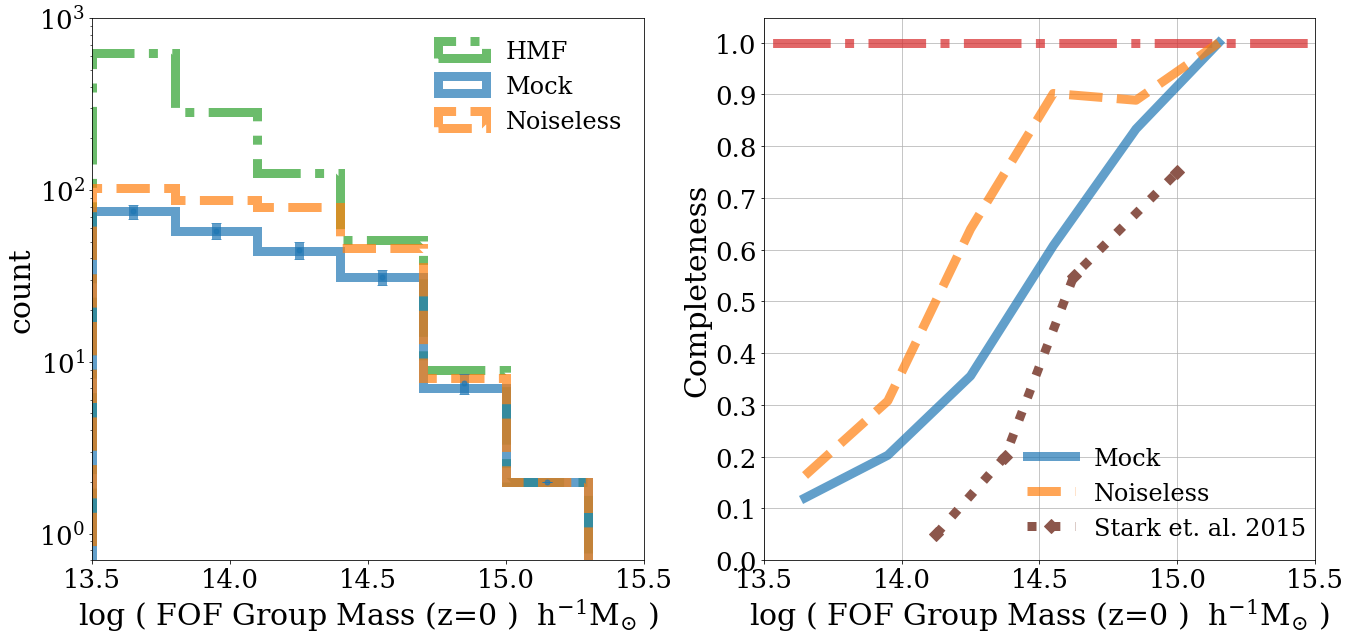

In [23]:
mass_func()

### Visualize the watersheds:

In [2]:
import h5py
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter as gf
import numpy as np
import importlib
plt.style.use('Notebook.mystyle')

In [5]:
def progenitors_for_paper():
    from scipy.ndimage import label
    import os
    import lytomo_watershed
    importlib.reload(lytomo_watershed)
    from lytomo_watershed import plot_simulation as ps
    from lytomo_watershed import minima
    from lytomo_watershed import progenitor_particles
    
    data_dir = '/run/media/mahdi/HD2/Lya/LyTomo_data/'
    mock_map = np.fromfile(os.path.join(data_dir, 'mock_maps_z2.4/map_TNG_z2.4_n1.dat')).reshape(205,205,205)
    mock_map = gf(mock_map, 4, mode='wrap')
    mock_map /= np.std(mock_map)
    
    lmap = h5py.File(os.path.join(data_dir,'watersheds_z2.4/mocks/n1/labeled_map_TNG_z2.4_n1_sigma4_th2.35_lc2.00.hdf5'),'r')['map'][:]
    peaks = h5py.File(os.path.join(data_dir, 'watersheds_z2.4/mocks/n1/peaks_TNG_z2.4_n1_sigma4_th2.35_lc2.00.hdf5'),'r')
    
    #DM_prog_all = progenitor_particles.make_full_prog_map()
    DM_prog_all = None
    all_clusters = h5py.File(os.path.join(data_dir,'progenitors/clusters_TNG300-1.hdf5'),'r')
    fcofm = h5py.File(os.path.join(data_dir,'progenitors/cofm_progenitors.hdf5'),'r')
    #islands = minima.get_islands()
    islands=None
    
    fig, ax = plt.subplots(2,4, figsize=(20,10))
    for i, z in enumerate(range(136,152,2)):
        volume = np.zeros(shape=(205,205,205), dtype=bool)
        volume[0:100,0:100,z:z+1] = True
        
        ax_label=[]
        
        if i in [0,4]:
            ax_label=['y']
            ax[int(i/4),i%4].tick_params(axis='x', colors='k')
            ax[int(i/4),i%4].tick_params(axis='y', colors='k')
            ax[int(i/4),i%4].yaxis.label.set_color('k')
            ax[int(i/4),i%4].xaxis.label.set_color('k')
            #lsize = len(ax.get_yticklabels())
            #plt.setp(, )

        if i in [4,5,6,7]:
            ax_label=['x']
            ax[int(i/4),i%4].tick_params(axis='x', colors='k')
            ax[int(i/4),i%4].tick_params(axis='y', colors='k')
            ax[int(i/4),i%4].yaxis.label.set_color('k')
            ax[int(i/4),i%4].xaxis.label.set_color('k')
        if i==4:

            ax_label=['x', 'y']
            ax[int(i/4),i%4].tick_params(axis='x', colors='k')
            ax[int(i/4),i%4].tick_params(axis='y', colors='k')
            ax[int(i/4),i%4].yaxis.label.set_color('k')
            ax[int(i/4),i%4].xaxis.label.set_color('k')
        if i==7 :
            colorbar=True
        else:
            colorbar=False
        legend=False
        if i==7 :
            legend = True

        ps.prog_parts_paper(fig, ax[int(i/4),i%4], volume, DM_prog_all=DM_prog_all, fcofm=fcofm, 
                            all_clusters=all_clusters, lmap=lmap, islands=islands, peaks=peaks, 
                            mock_map=mock_map, colorbar=colorbar,legend=legend, title='z ='+str(z)+' cMpc/h',
                            markersize=140, ax_label=ax_label, vmin = -3.48, vmax=4., boxsize=205)
        
    fig.legend(loc='upper center', bbox_to_anchor=(0.5,1), ncol=4, fontsize=20, facecolor='darkgray')
    plt.subplots_adjust(hspace=0.03, wspace=0.02)
    fig.savefig('./figures/DM_prog_flux.pdf',transparent=True, bbox_inches='tight')

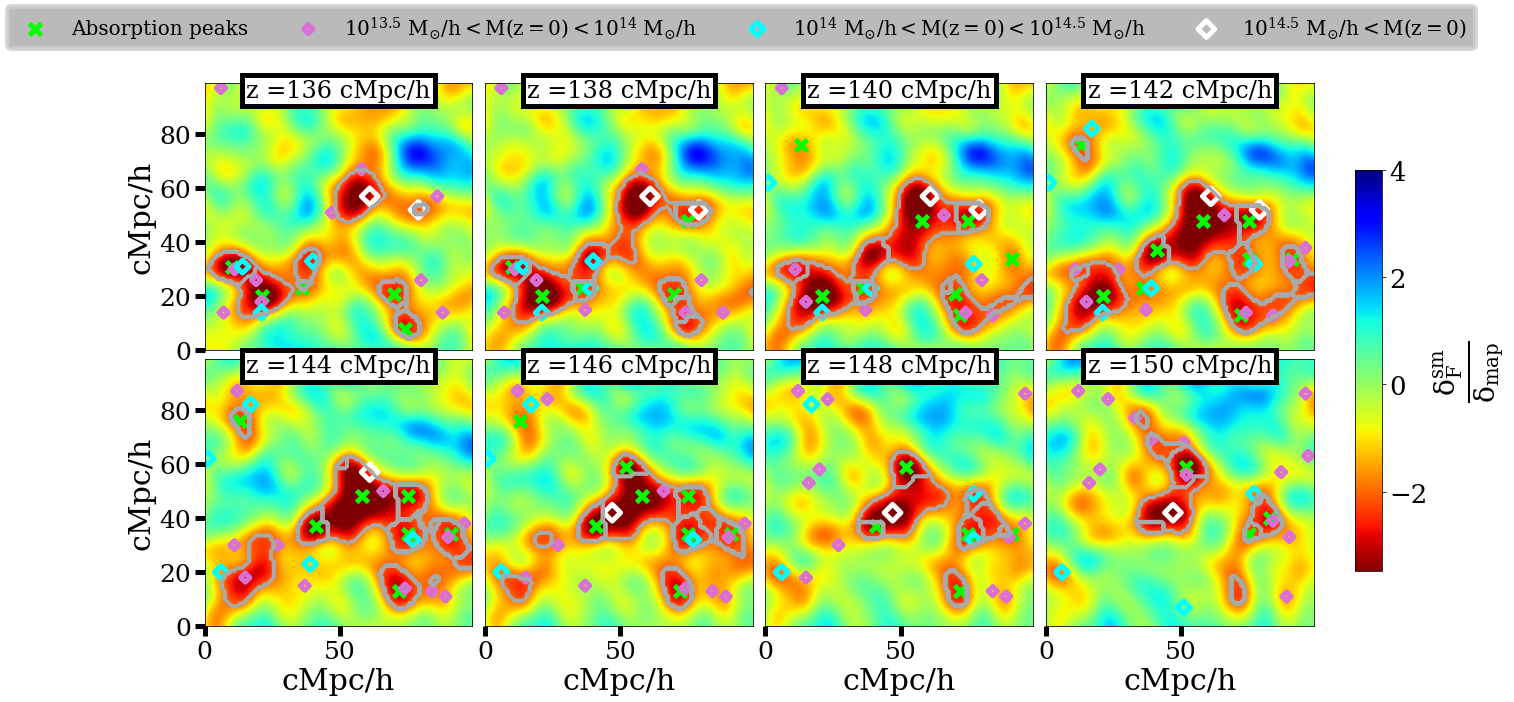

In [6]:
progenitors_for_paper()